## <span style="color:darkblue; font-weight:bold"> A. Setups </span>

In [5]:
import os
print(os.getcwd())
os.chdir('C:/Users/ADMIN/Desktop/act61-mfe-prediction-competition')

C:\Users\ADMIN\Desktop\act61-mfe-prediction-competition


In [6]:
#Import modules=================================================================================================================
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance

#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

#from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

In [7]:
#Setup some visual properties=================================================================================================================
plt.style.use('seaborn-v0_8') #All subsequent plots will have this style
mpl.rcParams['font.family'] = "Tahoma" #All subsequent plots will have this font
%matplotlib inline

In [47]:
#Read files=====================================================================================================================
train = pd.read_csv("cleaned_train.csv")
print(train.info())

test = pd.read_csv("cleaned_test.csv")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6000 non-null   int64  
 1   selling_price  6000 non-null   int64  
 2   km_driven      6000 non-null   int64  
 3   fuel           6000 non-null   object 
 4   seller_type    6000 non-null   object 
 5   transmission   6000 non-null   object 
 6   owner          6000 non-null   object 
 7   mileage        5828 non-null   float64
 8   engine         5841 non-null   float64
 9   max_power      5840 non-null   float64
 10  torque         5840 non-null   float64
 11  seats          5841 non-null   float64
 12  brand          6000 non-null   object 
dtypes: float64(5), int64(3), object(5)
memory usage: 609.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------   

In [34]:
#Import helper functions=====================================================================================================================
%run Helper_Functions.ipynb

## <span style="color:darkblue; font-weight:bold"> B. EDA </span>

In [48]:
train

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
0,2018,850000,9500,Diesel,Individual,Manual,First Owner,25.903614,1497.0,108.50,260.00,5.0,Tata
1,2018,750000,30000,Diesel,Individual,Manual,First Owner,25.530120,1396.0,88.76,219.66,5.0,Hyundai
2,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,15.120482,2982.0,168.50,360.00,7.0,Toyota
3,2015,795000,35000,Petrol,Individual,Manual,First Owner,22.986486,1591.0,121.30,154.90,5.0,Hyundai
4,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,21.686747,1969.0,190.00,400.00,5.0,Volvo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2010,235000,50000,Petrol,Individual,Manual,First Owner,25.675676,998.0,66.10,90.00,5.0,Maruti
5996,2018,390000,40000,CNG,Individual,Manual,First Owner,26.600000,998.0,58.16,77.00,5.0,Maruti
5997,2018,450000,75000,Petrol,Individual,Manual,First Owner,27.432432,1199.0,84.00,114.00,5.0,Tata
5998,2011,250000,100000,Diesel,Individual,Manual,Second Owner,19.228916,2523.0,63.00,180.00,9.0,Mahindra


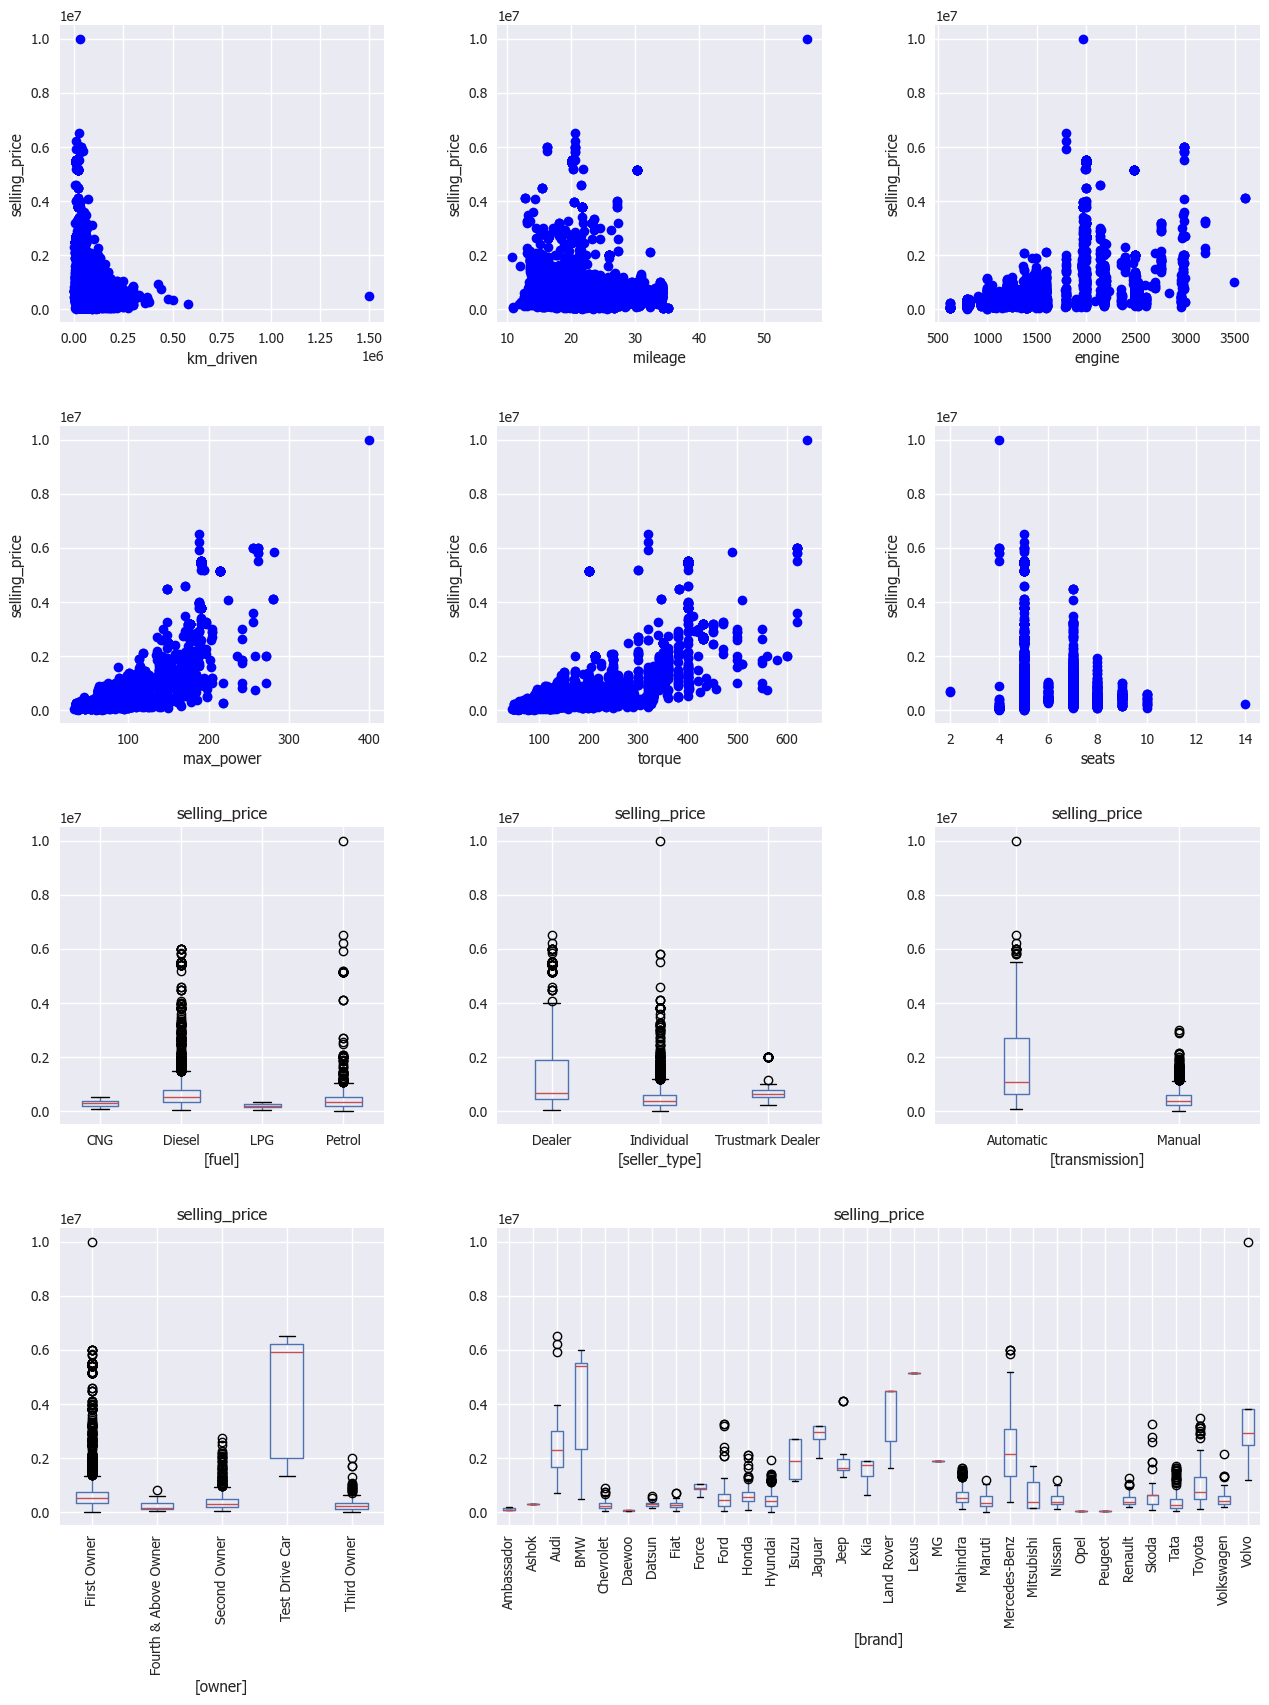

In [84]:
fig = plt.figure(figsize=(15, 20))
gs = mpl.gridspec.GridSpec(4, 3, wspace=0.35, hspace=0.35)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train.km_driven, train.selling_price, "bo")
ax.set_xlabel("km_driven"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[0, 1])
ax.plot(train.mileage, train.selling_price, "bo")
ax.set_xlabel("mileage"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[0, 2])
ax.plot(train.engine, train.selling_price, "bo")
ax.set_xlabel("engine"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 0])
ax.plot(train.max_power, train.selling_price, "bo")
ax.set_xlabel("max_power"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 1])
ax.plot(train.torque, train.selling_price, "bo")
ax.set_xlabel("torque"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 2])
ax.plot(train.seats, train.selling_price, "bo")
ax.set_xlabel("seats"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[2, 0])
df = pd.concat([train.selling_price, train.fuel], axis=1)
df.boxplot(by="fuel", ax=ax)

ax = fig.add_subplot(gs[2, 1])
df = pd.concat([train.selling_price, train.seller_type], axis=1)
df.boxplot(by="seller_type", ax=ax)

ax = fig.add_subplot(gs[2, 2])
df = pd.concat([train.selling_price, train.transmission], axis=1)
df.boxplot(by="transmission", ax=ax)

ax = fig.add_subplot(gs[3, 0])
df = pd.concat([train.selling_price, train.owner], axis=1)
df.boxplot(by="owner", ax=ax, rot=90)

ax = fig.add_subplot(gs[3, 1:3])
df = pd.concat([train.selling_price, train.brand], axis=1)
df.boxplot(by="brand", ax=ax, rot=90)


fig.suptitle('')
plt.show(); plt.close()

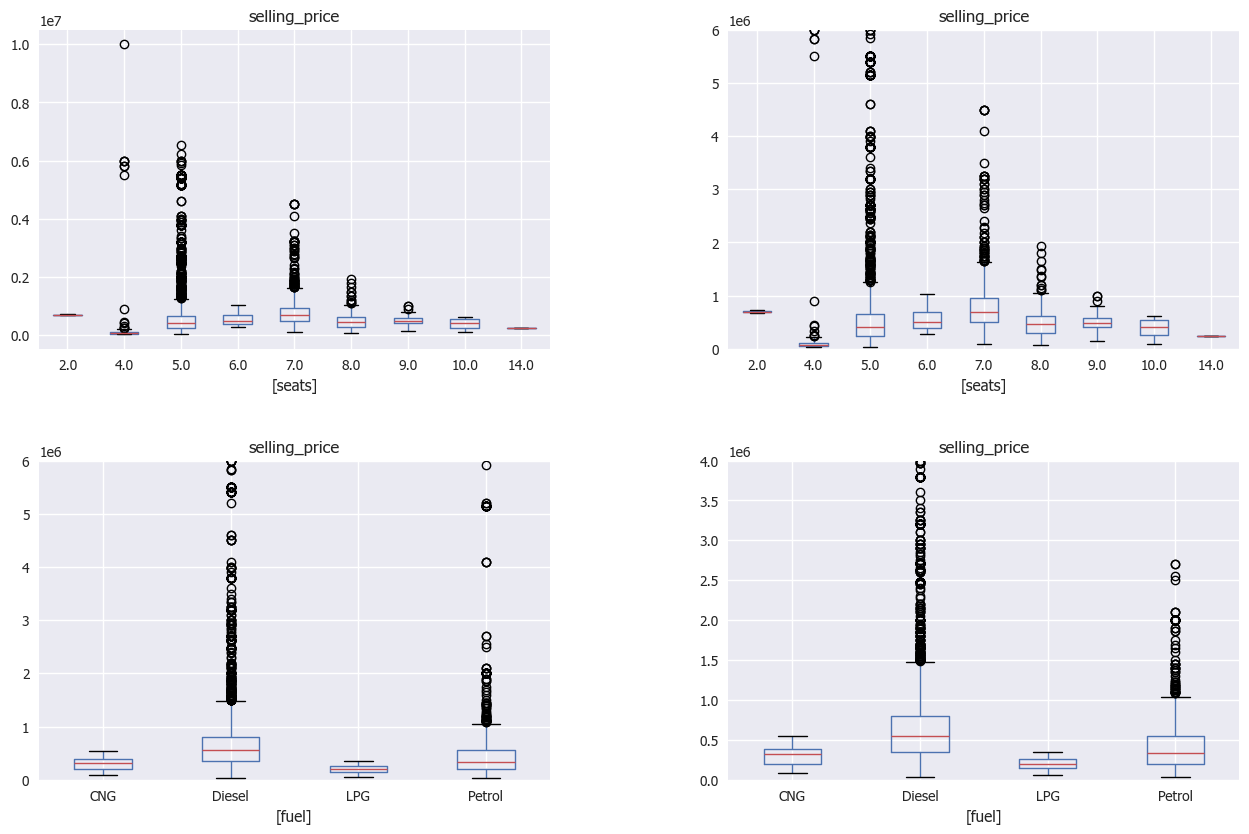

In [85]:
fig = plt.figure(figsize=(15, 10))
gs = mpl.gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.35)

ax = fig.add_subplot(gs[0, 0])
df = pd.concat([train.selling_price, train.seats], axis=1)
df.boxplot(by="seats", ax=ax)

ax = fig.add_subplot(gs[0, 1])
df = pd.concat([train.selling_price, train.seats], axis=1)
df.boxplot(by="seats", ax=ax)
ax.set_ylim(0, 0.6 * 10**7)

ax = fig.add_subplot(gs[1, 0])
df = pd.concat([train.selling_price, train.fuel], axis=1)
df.boxplot(by="fuel", ax=ax)
ax.set_ylim(0, 0.6 * 10**7)

ax = fig.add_subplot(gs[1, 1])
df = pd.concat([train.selling_price, train.fuel], axis=1)
df.boxplot(by="fuel", ax=ax)
ax.set_ylim(0, 0.4 * 10**7)


fig.suptitle('')
plt.show(); plt.close()

## <span style="color:darkblue; font-weight:bold"> C. Encoding some variables </span>

In [86]:
print("***Exclude some variables in train and test:")
Col_list_to_drop = ["fuel", "seller_type", "seats"]
train = train.drop(Col_list_to_drop, axis=1)
test = test.drop(Col_list_to_drop, axis=1)


print("\n***Encode owner:")
def Encode_owner(x):
    """
    Note: x is a string
    """
    if x == "First Owner": return 1
    if x == "Second Owner": return 2
    if x == "Third Owner": return 3
    if x == "Fourth & Above Owner": return 4
    if x == "Test Drive Car": return 5
    
train["owner"] = [Encode_owner(val) for val in train.owner]
test["owner"] = [Encode_owner(val) for val in test.owner]


print("\n***Standardizing engine and km_driven")
def Scale(s):
    return (s - s.mean()) / s.std()

train.engine = Scale(train.engine)
#train.mileage = Scale(train.mileage)
#train.max_power = Scale(train.max_power)
#train.torque= Scale(train.torque)
train.km_driven = Scale(train.km_driven)

test.engine = Scale(test.engine)
#test.mileage = Scale(test.mileage)
#test.max_power = Scale(test.max_power)
#test.torque= Scale(test.torque)
test.km_driven = Scale(test.km_driven)


print("\n***One-hot encode transmission, brand:")
train = pd.get_dummies(train, columns=["transmission", "brand"])
test = pd.get_dummies(test, columns=["transmission", "brand"])


print("\n***Add missing brands for both train and set")
Filter = [(x not in test.columns) for x in train.columns]
Cols_to_add = train.columns[Filter]
print("Brands in train but not in test:", Cols_to_add)

for i in Cols_to_add:
    if i == "selling_price": pass
    else: test[i] = [False] * len(test)

Filter = [(x not in train.columns) for x in test.columns]
Cols_to_add = test.columns[Filter]
print("Brands in test but not in train:", Cols_to_add)
        
        
print("\n***Align column order in train and test:")
train = train[sorted(train.columns)]
test = test[sorted(test.columns)]

***Exclude some variables in train and test:

***Encode owner:

***Standardizing engine and km_driven

***One-hot encode transmission, brand:

***Add missing brands for both train and set
Brands in train but not in test: Index(['selling_price', 'brand_Ashok', 'brand_Isuzu', 'brand_Kia',
       'brand_Land Rover', 'brand_Opel', 'brand_Peugeot'],
      dtype='object')
Brands in test but not in train: Index([], dtype='object')

***Align column order in train and test:


In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand_Ambassador        6000 non-null   bool   
 1   brand_Ashok             6000 non-null   bool   
 2   brand_Audi              6000 non-null   bool   
 3   brand_BMW               6000 non-null   bool   
 4   brand_Chevrolet         6000 non-null   bool   
 5   brand_Daewoo            6000 non-null   bool   
 6   brand_Datsun            6000 non-null   bool   
 7   brand_Fiat              6000 non-null   bool   
 8   brand_Force             6000 non-null   bool   
 9   brand_Ford              6000 non-null   bool   
 10  brand_Honda             6000 non-null   bool   
 11  brand_Hyundai           6000 non-null   bool   
 12  brand_Isuzu             6000 non-null   bool   
 13  brand_Jaguar            6000 non-null   bool   
 14  brand_Jeep              6000 non-null   

In [88]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand_Ambassador        2128 non-null   bool   
 1   brand_Ashok             2128 non-null   bool   
 2   brand_Audi              2128 non-null   bool   
 3   brand_BMW               2128 non-null   bool   
 4   brand_Chevrolet         2128 non-null   bool   
 5   brand_Daewoo            2128 non-null   bool   
 6   brand_Datsun            2128 non-null   bool   
 7   brand_Fiat              2128 non-null   bool   
 8   brand_Force             2128 non-null   bool   
 9   brand_Ford              2128 non-null   bool   
 10  brand_Honda             2128 non-null   bool   
 11  brand_Hyundai           2128 non-null   bool   
 12  brand_Isuzu             2128 non-null   bool   
 13  brand_Jaguar            2128 non-null   bool   
 14  brand_Jeep              2128 non-null   

## <span style="color:darkblue; font-weight:bold"> D. Model tuning </span>

In [100]:
X_train = train.loc[:, train.columns != "selling_price"].copy()
y_train = train.selling_price.copy()

X_test = test.loc[:, test.columns != "selling_price"].copy()

In [131]:
print("***Parameter Tuning:")
param_space = {
    'n_estimators': (300, 350),               # Number of trees
    'max_depth': [7],                    # Maximum tree depth
    'learning_rate': [0.065], #(0.05, 0.1, 'log-uniform'),
    'colsample_bytree':[0.833], #(0.6, 1, 'uniform'),
    "subsample":[0.7289], #(0.7, 1, "uniform"),
    "reg_alpha":[0.0054], #(0, 0.01, "uniform"),
    "reg_lambda":[1.486], #(1, 2, "uniform"),
    "gamma":[0],
    "min_child_weight":[1/np.sqrt(37)]
}


cv = KFold(n_splits=10, shuffle=True, random_state=113)

bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=113),
    search_spaces=param_space,
    n_iter=10,  #Number of parameter settings to sample
    cv=cv,
    n_jobs=-1,
    random_state=113,
    scoring='neg_mean_squared_error',
    refit=True) #Refit the best parameters on train set

bayes_search.fit(X_train, y_train);

***Parameter Tuning:


In [138]:
print("***Best combo:\n", bayes_search.best_params_)

print("\n***Best combo result:")
print("Mean Negative MSE:", bayes_search.cv_results_['mean_test_score'][bayes_search.best_index_])
print("STD Negative MSE:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

***Best combo:
 OrderedDict({'colsample_bytree': 0.833, 'gamma': 0, 'learning_rate': 0.065, 'max_depth': 7, 'min_child_weight': 0.1643989873053573, 'n_estimators': 350, 'reg_alpha': 0.0054, 'reg_lambda': 1.486, 'subsample': 0.7289})

***Best combo result:
Mean Negative MSE: -17606204378.81265
STD Negative MSE: 14223054396.989496


In [139]:
print("***Fitting the best model:")
y_pred = bayes_search.predict(X_test)
y_pred

***Fitting the best model:


array([ 658383.25,  792200.75,  393034.97, ...,  162116.16, 1066818.9 ,
        384553.56], dtype=float32)

## <span style="color:darkblue; font-weight:bold"> E. Export predicted data </span>

In [116]:
sample = pd.read_csv("sample.csv")
print(sample.info(), "\n")

sample["Predicted"] = sample["Predicted"].astype(float)
print(sample.info(), "\n")

sample["Predicted"] = y_pred
sample.to_csv('sample_final.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         2128 non-null   int64
 1   Predicted  2128 non-null   int64
dtypes: int64(2)
memory usage: 33.4 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2128 non-null   int64  
 1   Predicted  2128 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 33.4 KB
None 

